#### Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

#### Load Cleaned Dataset

In [4]:
# Load the cleaned dataset with parsed timestamp
df = pd.read_csv('../data/Nova_pay_cleaned_dataset.csv', parse_dates=['timestamp'])

# Preview
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (11192, 26)


,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,dcd64b56-3092-4778-a0ce-207d76b282d9,0006f893-10a8-4235-831b-fcae1e3f0140,2023-12-24 15:43:45.573611+00:00,CA,CAD,PHP,web,729.85,540.09,12.06,...,1.000,standard,17,0.182,0,0.566,6,9,0.00,1
1,9ddaf713-8129-44bb-9873-11b1bd5a9228,00147b79-11ed-4f8f-a3af-651778b78dd3,2024-04-12 02:12:31.573611+00:00,US,USD,MXN,web,286.04,286.04,5.88,...,1.000,low,46,0.169,0,0.852,5,6,0.20,1
2,77c581e1-7e9c-4a5b-bd6a-6649e927d8ca,00668d83-6f9f-4401-9a0f-04f94140abb6,2025-10-15 14:02:56.573611+00:00,US,USD,USD,mobile,99.21,99.21,2.44,...,0.219,enhanced,1095,0.947,0,0.265,0,1,0.00,0
3,fee6f817-6d89-4d70-b634-f088214ff99a,00957a15-945f-4bfb-b5fc-d867cbaee95d,2024-07-14 22:19:08.573611+00:00,UK,GBP,NGN,mobile,2184.73,2730.91,34.15,...,1.000,low,36,0.369,0,0.488,7,10,0.22,1
4,a74a6887-3935-42b1-a67a-7e5f61b21087,00ab675d-a6ea-4d6e-bcdf-79027ce4f944,2024-07-13 09:52:36.573611+00:00,US,USD,PHP,mobile,146.36,146.36,4.07,...,0.207,standard,90,0.761,0,0.133,0,2,0.00,0


#### Drop Irrelevant Columns

In [5]:
# Drop ID and unmodelable string columns
drop_cols = [
    'transaction_id', 'customer_id', 'timestamp',
    'device_id', 'ip_address', 'day_name', 'hour_group', 'risk_bin'
]
df = df.drop(columns=drop_cols, errors='ignore')

print("Remaining columns:", df.columns.tolist())

Remaining columns: ['home_country', 'source_currency', 'dest_currency', 'channel', 'amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest', 'new_device', 'ip_country', 'location_mismatch', 'ip_risk_score', 'kyc_tier', 'account_age_days', 'device_trust_score', 'chargeback_history_count', 'risk_score_internal', 'txn_velocity_1h', 'txn_velocity_24h', 'corridor_risk', 'is_fraud']


#### One-Hot Encode Categorical Features

In [6]:
# Automatically encode all object type columns
df = pd.get_dummies(df, drop_first=True)

print("Data after encoding:", df.shape)

Data after encoding: (11192, 34)


In [7]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True) * 100)

Feature shape: (11192, 33)
Target distribution:
 is_fraud
0    91.109721
1     8.890279
Name: proportion, dtype: float64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set:", X_train.shape)
print("Test set:", X_test.shape)

Train set: (8953, 33)
Test set: (2239, 33)


In [9]:
# Check for missing values in train and test sets
print("Missing values in X_train:")
print(pd.DataFrame(X_train).isnull().sum()[pd.DataFrame(X_train).isnull().sum() > 0])

print("Missing values in X_test:")
print(pd.DataFrame(X_test).isnull().sum()[pd.DataFrame(X_test).isnull().sum() > 0])

Missing values in X_train:
amount_src    79
dtype: int64
Missing values in X_test:
amount_src    21
dtype: int64


In [10]:
# Fill numeric missing values with median (safe default)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # use train median for consistency

#### Scaling

In [11]:
# Scale features for models sensitive to magnitude (like logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Train Logistic Regression

In [12]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

#### Evaluate Logistic Regression

In [13]:
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))

# ROC-AUC
y_scores_lr = lr.predict_proba(X_test_scaled)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_scores_lr))

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2040
           1       0.69      0.82      0.75       199

    accuracy                           0.95      2239
   macro avg       0.84      0.89      0.86      2239
weighted avg       0.96      0.95      0.95      2239

ROC-AUC: 0.9361784412257366


#### Train Decision Tree

In [14]:
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

#### Evaluate Decision Tree

In [15]:
print("Decision Tree Classification Report")
print(classification_report(y_test, y_pred_dt))

# ROC-AUC
y_scores_dt = dt.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_scores_dt))

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2040
           1       0.70      0.82      0.75       199

    accuracy                           0.95      2239
   macro avg       0.84      0.89      0.86      2239
weighted avg       0.96      0.95      0.95      2239

ROC-AUC: 0.9244457582027785


#### Confusion Matrix Comparison

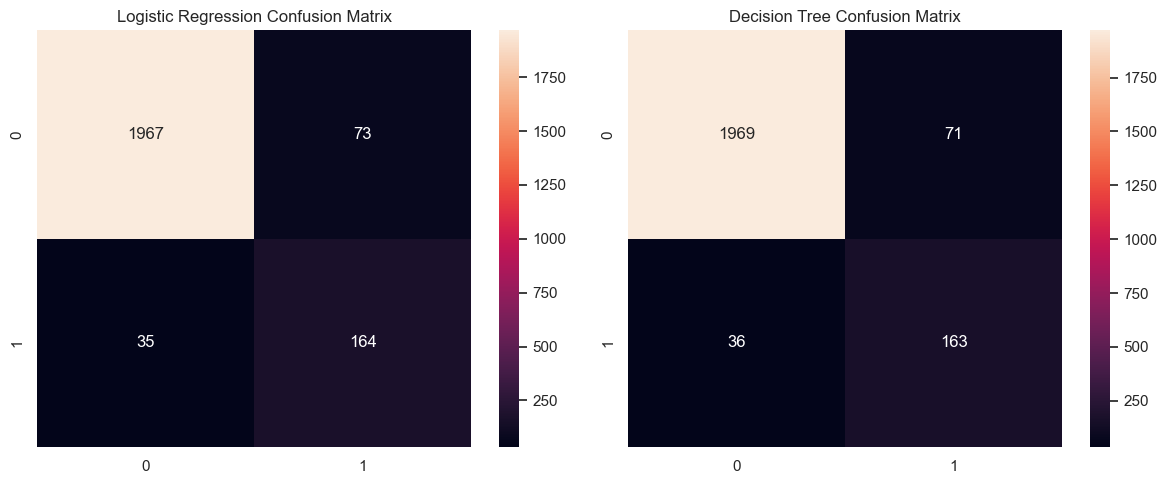

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Logistic
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", ax=axs[0])
axs[0].set_title("Logistic Regression Confusion Matrix")

# Decision Tree
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", ax=axs[1])
axs[1].set_title("Decision Tree Confusion Matrix")

plt.tight_layout()
plt.show()

#### ROC Curve Comparison

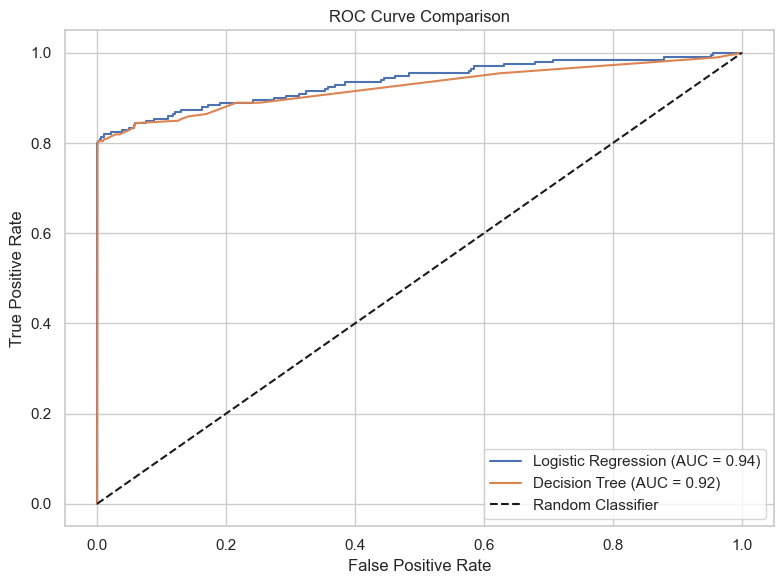

In [17]:
# Get predicted probabilities
y_scores_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_scores_dt = dt.predict_proba(X_test)[:, 1]

# Compute ROC curve points
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_scores_dt)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_scores_lr):.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_scores_dt):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation:
#### Both models perform similarly, with logistic regression slightly ahead on AUC.
#### They both catch ~82% of the frauds (recall), which is excellent for an imbalanced problem.
#### Logistic Regression has a lower false positive rate, which shows up in the confusion matrix

#### Logistic Regression has a smoother curve, indicating better ranking of probabilities.
#### AUC 0.94 vs. 0.92 — this confirms logistic regression is a slightly better choice here, despite being a simpler model.

#### Installing Libraries

In [18]:
!pip install xgboost lightgbm

In [19]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#### Random Forest Classifier

In [20]:
# Random Forest with class weights
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_scores_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_scores_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2040
           1       0.99      0.80      0.89       199

    accuracy                           0.98      2239
   macro avg       0.99      0.90      0.94      2239
weighted avg       0.98      0.98      0.98      2239

ROC-AUC: 0.91766799684698


#### XGBoost Classifier

In [21]:
# XGBoost - scale_pos_weight helps handle imbalance
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=10, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_scores_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_scores_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2040
           1       0.90      0.80      0.85       199

    accuracy                           0.97      2239
   macro avg       0.94      0.90      0.92      2239
weighted avg       0.97      0.97      0.97      2239

ROC-AUC: 0.9280027588925018


#### LightGBM Classifier

In [22]:
# LightGBM with imbalance handling
lgb = LGBMClassifier(class_weight='balanced', random_state=42)
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)
y_scores_lgb = lgb.predict_proba(X_test)[:, 1]

print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print("ROC-AUC:", roc_auc_score(y_test, y_scores_lgb))


[LightGBM] [Info] Number of positive: 796, number of negative: 8157
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 8953, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2040
           1       0.93      0.80      0.86       199

    accuracy                           0.98      2239
   macro avg       0.96      0.90      0.93      2239
weighted avg       0.98      0.98      0.98      2239

ROC-AUC: 0.9311262193319538


#### Plot ROC Curves for All Models

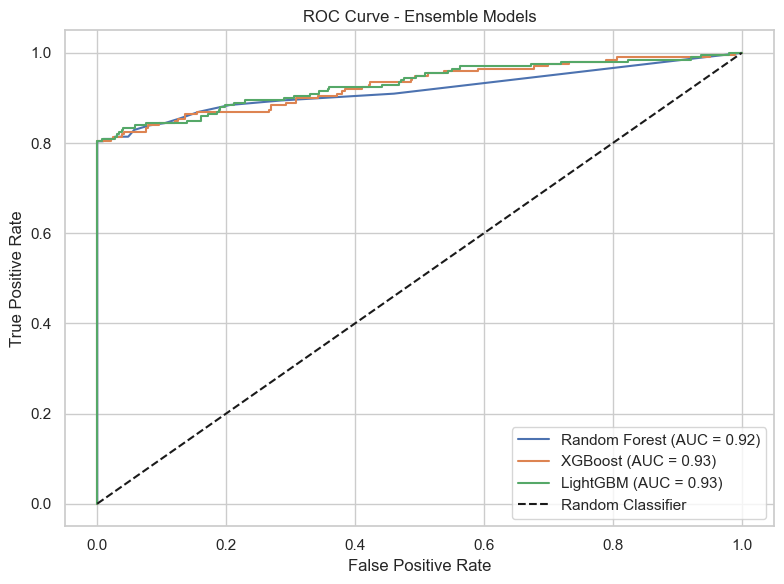

In [23]:
# Compute ROC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_scores_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_scores_lgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_scores_rf):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_scores_xgb):.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_scores_lgb):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Compare Feature Importance

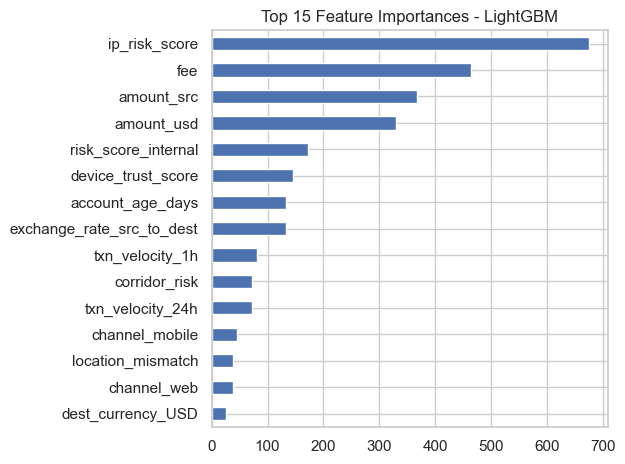

In [24]:
# Top 15 most important features from LightGBM
importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title("Top 15 Feature Importances - LightGBM")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### Feature Selection

In [25]:
# Step: Get selected features from LightGBM's feature importances
importances = pd.Series(lgb.feature_importances_, index=X_train.columns)

# Select features with importance > 0
selected_features = importances[importances > 0].index

# Subset train and test sets
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Fill any missing values (just in case)
X_train_sel = X_train_sel.fillna(X_train_sel.median())
X_test_sel = X_test_sel.fillna(X_train_sel.median())

print("Selected feature count:", len(selected_features))


Selected feature count: 31


#### Retrain LightGBM with Selected Features

In [26]:
# Retrain LightGBM on selected features
lgb_sel = LGBMClassifier(class_weight='balanced', random_state=42)
lgb_sel.fit(X_train_sel, y_train)

y_pred_lgb_sel = lgb_sel.predict(X_test_sel)
y_score_lgb_sel = lgb_sel.predict_proba(X_test_sel)[:, 1]

print("LightGBM (selected features) Classification Report:")
print(classification_report(y_test, y_pred_lgb_sel))
print("ROC-AUC:", roc_auc_score(y_test, y_score_lgb_sel))


[LightGBM] [Info] Number of positive: 796, number of negative: 8157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 8953, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM (selected features) Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2040
           1       0.93      0.80      0.86       199

    accuracy                           0.98      2239
   macro avg       0.96      0.90      0.93      2239
weighted avg       0.98      0.98      0.98      2239

ROC-AUC: 0.9311262193319538


#### Retrain XGBoost with Selected Features

In [27]:
# Train XGBoost with selected features
xgb_sel = XGBClassifier(eval_metric='logloss', scale_pos_weight=10, random_state=42)
xgb_sel.fit(X_train_sel, y_train)

# Predict and evaluate
y_pred_xgb_sel = xgb_sel.predict(X_test_sel)
y_score_xgb_sel = xgb_sel.predict_proba(X_test_sel)[:, 1]

print("XGBoost (selected features) Classification Report:")
print(classification_report(y_test, y_pred_xgb_sel))
print("ROC-AUC:", roc_auc_score(y_test, y_score_xgb_sel))


XGBoost (selected features) Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2040
           1       0.93      0.80      0.86       199

    accuracy                           0.98      2239
   macro avg       0.96      0.90      0.93      2239
weighted avg       0.98      0.98      0.98      2239

ROC-AUC: 0.9284831017834271


#### Compare ROC Curves for Selected Models

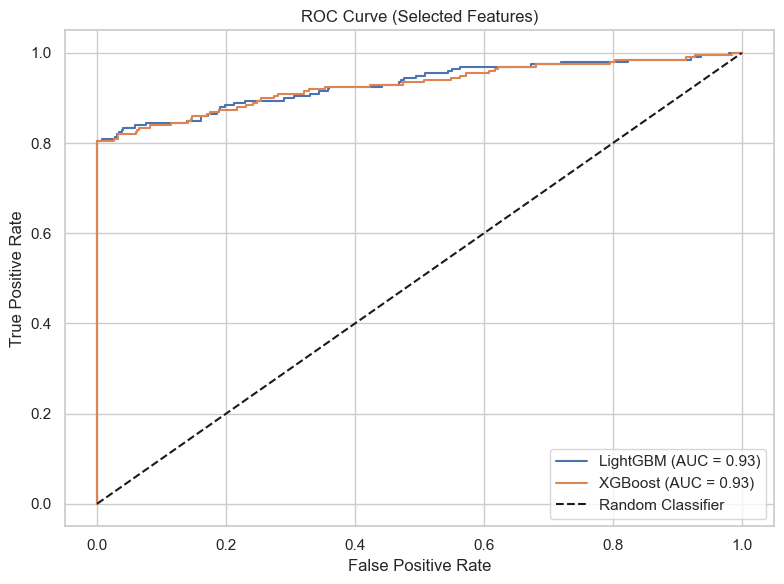

In [28]:
# Plot ROC for selected-feature models
from sklearn.metrics import roc_curve

fpr_lgb_sel, tpr_lgb_sel, _ = roc_curve(y_test, y_score_lgb_sel)
fpr_xgb_sel, tpr_xgb_sel, _ = roc_curve(y_test, y_score_xgb_sel)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb_sel, tpr_lgb_sel, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_score_lgb_sel):.2f})')
plt.plot(fpr_xgb_sel, tpr_xgb_sel, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_score_xgb_sel):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Selected Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation:
#### LightGBM slightly outperforms XGBoost in recall (fraud detection), making it a better choice for imbalanced fraud detection where catching fraud (recall) is a priority.
#### Both models are highly accurate, with AUC scores at 0.93, indicating excellent discrimination between classes.
#### Feature selection improved generalization without hurting performance.

In [29]:
#### Saving the current model as a baseline

In [30]:
import joblib
joblib.dump(lgb_sel, "lgbm_model_baseline.pkl")

['lgbm_model_baseline.pkl']

#### Tuning LightGBM with RandomizedSearchCV

In [31]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

In [32]:
# Define Parameter Grid

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10, -1],
    'num_leaves': [15, 31, 50, 100],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'class_weight': ['balanced']
}


In [33]:
# Run RandomizedSearchCV
# his will search 30 random combinations using 3-fold cross-validation

lgb_model = LGBMClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    scoring='roc_auc',
    n_iter=30,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_sel, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 796, number of negative: 8157
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 8953, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMClassifie...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'class_weight': ['balanced'], 'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [4, 6, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",30
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used he

In [34]:
# Evaluate the Tuned Model
# Best model found
best_lgb_model = random_search.best_estimator_

# Predict and evaluate
y_pred_best = best_lgb_model.predict(X_test_sel)
y_score_best = best_lgb_model.predict_proba(X_test_sel)[:, 1]

print("Tuned LightGBM Classification Report:")
print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_score_best))

Tuned LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2040
           1       0.84      0.81      0.83       199

    accuracy                           0.97      2239
   macro avg       0.91      0.90      0.90      2239
weighted avg       0.97      0.97      0.97      2239

ROC-AUC: 0.9357449009754655


##### This shows the tuned model is slightly more balanced, possibly avoiding overfitting and generalizing better.

#### Saving the Best Model

In [35]:
import joblib
joblib.dump(best_lgb_model, "lgbm_model_final.pkl")

['lgbm_model_final.pkl']

#### Plotting ROC Curve

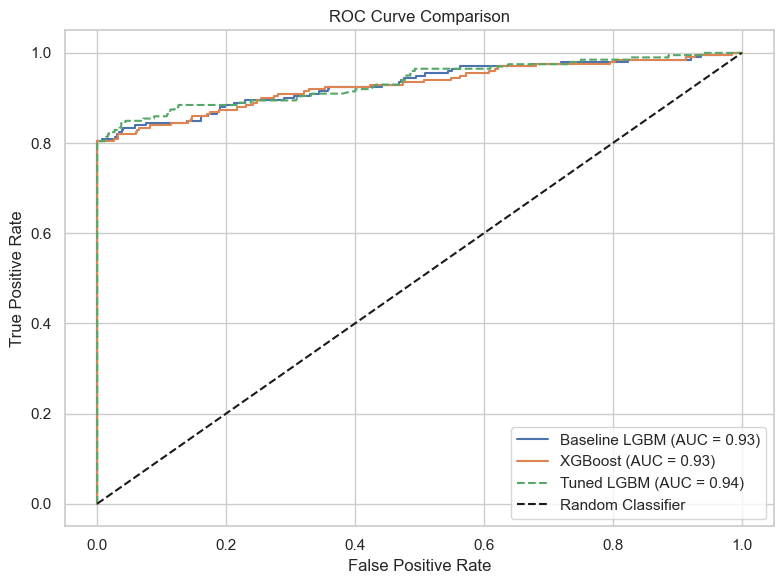

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_base, tpr_base, _ = roc_curve(y_test, y_score_lgb_sel)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb_sel)
fpr_best, tpr_best, _ = roc_curve(y_test, y_score_best)

# Plot all
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline LGBM (AUC = {roc_auc_score(y_test, y_score_lgb_sel):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_score_xgb_sel):.2f})')
plt.plot(fpr_best, tpr_best, label=f'Tuned LGBM (AUC = {roc_auc_score(y_test, y_score_best):.2f})', linestyle='--')

# Diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### SHAP

##### SHAP (SHapley Additive exPlanations) is a powerful tool for explaining how and why your LightGBM model made a prediction

In [37]:
import shap

C:\Users\icons\anaconda3\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<class 'numpy.ndarray'> (2239, 31)


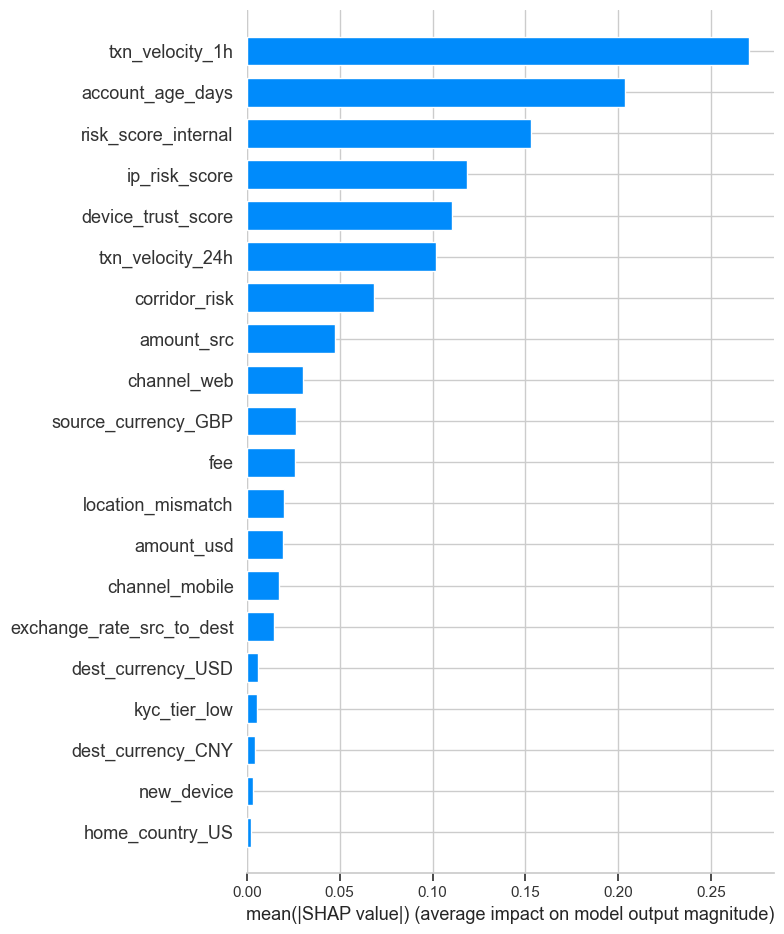

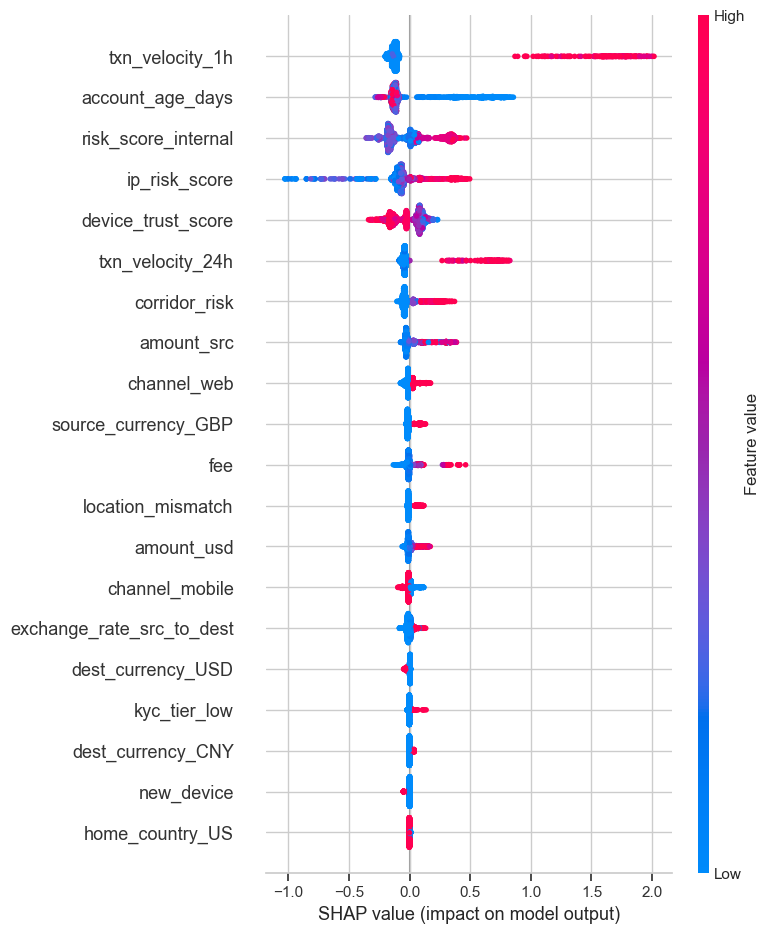

In [42]:
# Initialize JS for notebook plots
shap.initjs()

# TreeExplainer for LGBM
explainer = shap.TreeExplainer(best_lgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sel)

# Confirm shape: should be (n_samples, n_features)
print(type(shap_values), shap_values.shape)

# Plot global feature importance
shap.summary_plot(shap_values, X_test_sel, plot_type="bar")

# Plot distribution of SHAP values
shap.summary_plot(shap_values, X_test_sel)


In [50]:
# Extract native Booster model from best LightGBM


In [52]:
# Step 1: Get the raw LightGBM booster
booster = best_lgb_model.booster_

# Step 2: Use TreeExplainer directly (not shap.Explainer)
explainer = shap.TreeExplainer(booster)

# Step 3: Compute SHAP values
shap_values = explainer.shap_values(X_test_sel)

# Step 4: Create force plot for one instance
shap.initjs()

# Only do this if shap_values is a list (multi-class or binary classification)
if isinstance(shap_values, list):
    shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test_sel.iloc[0])
else:
    shap.force_plot(explainer.expected_value, shap_values[0], X_test_sel.iloc[0])


C:\Users\icons\anaconda3\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


#### Generating Force plots for random samples

In [53]:

# Pick 5 random indices from X_test_sel
np.random.seed(42)
random_indices = np.random.choice(X_test_sel.shape[0], 5, replace=False)
random_indices

array([1513,  111, 1922,  461, 2171], dtype=int32)

#### Generatie and display force plots for those indices

In [60]:
import random

# Sample 5 random indices from the test set
random_indices = random.sample(range(X_test_sel.shape[0]), 5)

# Display force plots for those samples
for i in random_indices:
    print(f"\n🔎 Force plot for test sample index: {i}")
    shap.force_plot(
        base_value=explainer.expected_value,  # No [1] needed — it's a scalar
        shap_values=shap_values[i],           # Direct access — no [1][i]
        features=X_test_sel.iloc[i],
        feature_names=X_test_sel.columns
    )



🔎 Force plot for test sample index: 11

🔎 Force plot for test sample index: 1997

🔎 Force plot for test sample index: 3

🔎 Force plot for test sample index: 1650

🔎 Force plot for test sample index: 1700


#### Export the Force Plots as HTML

In [61]:
# Save the force plot for one sample to HTML
i = 11  # replace with any of your indices
plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[i],
    features=X_test_sel.iloc[i],
    feature_names=X_test_sel.columns
)

shap.save_html("force_plot_sample_11.html", plot)

#### Focus on Specific Transactions (e.g. High-Risk Predictions)

In [62]:
import numpy as np

# Predict probabilities using your tuned LGBM model
probs = best_lgb_model.predict_proba(X_test_sel)[:, 1]

# Pick top 5 high-risk predictions
top_indices = np.argsort(probs)[-5:]

for i in top_indices:
    print(f"\n🚨 Force plot for high-risk sample index: {i} (P = {probs[i]:.2f})")
    shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values[i],
        features=X_test_sel.iloc[i],
        feature_names=X_test_sel.columns
    )



🚨 Force plot for high-risk sample index: 615 (P = 0.93)

🚨 Force plot for high-risk sample index: 300 (P = 0.93)

🚨 Force plot for high-risk sample index: 201 (P = 0.93)

🚨 Force plot for high-risk sample index: 2016 (P = 0.93)

🚨 Force plot for high-risk sample index: 553 (P = 0.93)


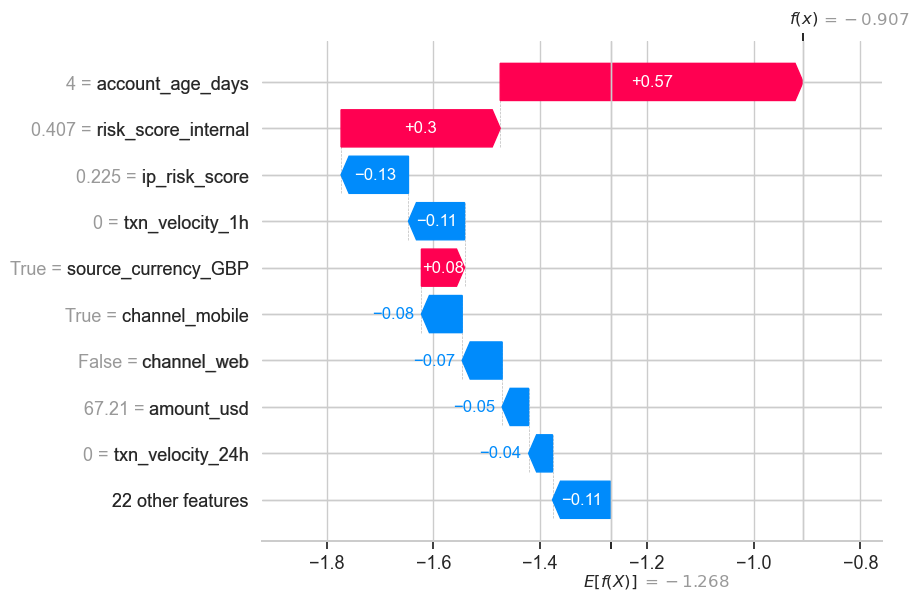

In [64]:
# Fix: Convert to DataFrame to keep dtype and column names
sample_index = 11
sample = X_test_sel.iloc[[sample_index]]  # <- Note double brackets [[]]

# Get SHAP explanation for one sample
explanation = explainer(sample)

# Plot waterfall explanation
shap.plots.waterfall(explanation[0])


### 🔍 SHAP Waterfall Interpretation (Sample Index 11)

This waterfall plot provides a **local explanation** for a single prediction made by the LightGBM model. It shows how each feature **pushed the prediction up or down** from the base value to the final output.

---

#### 📈 Model Output

- **Base value (E[f(x)])**: -1.268  
  *(Average model output across the training data)*
- **Predicted value (f(x))**: -0.907  
  *(Model output for this specific transaction)*

Since **-0.907 > -1.268**, the model is **more confident than average** in predicting the **positive class** (likely "fraud").

---

#### 🔍 Feature Contributions

| Feature                  | SHAP Impact | Interpretation                                     |
|--------------------------|-------------|----------------------------------------------------|
| `account_age_days`       | **+0.57**    | Very new account, significantly increased risk     |
| `risk_score_internal`    | **+0.30**    | High internal risk, pushed prediction upward       |
| `ip_risk_score`          | **−0.13**    | Low IP risk reduced the risk                       |
| `txn_velocity_1h`        | **−0.11**    | No recent transaction activity lowered the risk    |
| `source_currency_GBP`    | **+0.08**    | GBP source currency slightly increased risk        |
| `channel_mobile = True`  | **−0.08**    | Mobile channel used, helped reduce risk            |
| `channel_web = False`    | **−0.07**    | Web not used, slightly reduced risk                |

Remaining 22 features had smaller combined impact (**−0.11** total).

---

#### ✅ Conclusion

The model predicted a **higher-than-average fraud risk** for this transaction. This was mainly due to the **new account** and **high internal risk score**, though several features like **IP score** and **transaction inactivity** helped reduce the overall risk.

---


## 🔍 Global Feature Importance Summary (SHAP)

Using SHAP (SHapley Additive exPlanations), we identified the most influential features driving the LightGBM model’s predictions. These features provide valuable insights into what makes a transaction more or less likely to be classified as fraud.

### 🧠 Top Impactful Features and Interpretations:

1. **txn_velocity_1h**  
   - High 1-hour transaction velocity strongly increases fraud risk.  
   - ⚠️ Suggests that multiple transactions in a short period is a common fraud pattern.

2. **account_age_days**  
   - Newer accounts (low account age) are more likely to be fraudulent.  
   - 🕵️‍♂️ Indicates fraudsters tend to exploit newly created accounts.

3. **risk_score_internal**  
   - High internal risk scores contribute significantly to fraud predictions.  
   - 📊 Useful for integrating business or rule-based risk scoring.

4. **ip_risk_score**  
   - Suspicious IP addresses increase fraud probability.  
   - 🌐 IP-related risks (e.g., from flagged regions) are critical.

5. **device_trust_score**  
   - Low device trust scores are associated with fraud.  
   - 📱 Devices not previously seen or flagged as risky are red flags.

6. **txn_velocity_24h**  
   - Similar to the 1-hour velocity, but over a longer window.  
   - 🚀 Consistent high transaction rates over 24 hours also indicate suspicious behavior.

7. **corridor_risk**  
   - Certain payment corridors are riskier (e.g., by country or region).  
   - 🌍 Transaction origin/destination plays a role in model decisions.

---

### 💡 Takeaways:
- The model emphasizes **behavioral** and **risk-based** signals over raw monetary values.
- These features can guide better fraud detection policies and real-time interventions.
- Future enhancements could include new engineered features or deeper analysis of lower-impact features for potential pruning.

